# Nutritional Facts for most common foods
Source: https://www.kaggle.com/datasets/niharika41298/nutrition-details-for-most-common-foods  
(this is the larger dataset)

### Possible scenario ??:  
- A nutritionist creates custom diet plans for clients with medically-necessary dietary needs and wellness goals
- They want to be able to break down prescribed diets by the meal and the recipe, and to have the ability to specify calories, macro and micronutrients, and vitamins/minerals
- We have met with the client and obtained the following dataset detailing this information for an array of pre-defined meals. The client would like to be able to input their client's nutrition requirements and discover which meals to offer the client.  
- This input contains several parts:  
1. what the client likes and doesn't like to eat  
2. the nutritionist's breakdown specifying the client's prescription for that meal. 

- The returned result will be the meals which fit the client's taste and nutritional needs.  
- We will first study and organize the dataset to pick up on patterns across the food types  
- Then we can create a hypothetical plan for the best way for the end user (the nutritionist) to access and manipulate the data. Like a program, database, etc.  
- Further, we could see if the nutritionist's meal options are sufficient by examinig how many options are available for different dietary needs  

### Questions
1. What 

### Data Acquisition

preview of `nutrition.csv`:

In [ ]:
import pandas as pd
# create dataframe
nutrition = pd.read_csv("nutrition.csv")
# display a preview
nutrition.head()

In [ ]:
# print the number of cols, rows
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\nThere are " + str(nutrition.shape[1]) + " columns and " + str(nutrition.shape[0]) + " rows.\n~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")

In [ ]:
# basic statistics for the numerical columns
nutrition.describe()

In [ ]:
# show the data types
nutrition.dtypes

In [ ]:
# print all the column names
nutrition.columns

#### unique values

In [ ]:
# display the number of unique values in each categorical column
object_columns = nutrition.select_dtypes(include=['object']).columns  # set up a list of only the `object` dtypes

for column in object_columns:  # iterate thru columns list
    unique_count = nutrition[column].nunique()  # count how many unique values are present 
    print(f"There are {unique_count} different values in `{column}`.")  # print the number in the specified format

#### missing values
18% of the `saturated_fat` column is missing.

In [ ]:
# check for missing values
missing_values = nutrition.isnull().sum()

# calculate missing value counts for those columns where missing values are greater than zero
missing_values_df = pd.DataFrame(missing_values[missing_values > 0], columns=['Count Missing'])

# calculate the percentage of missing values for each column
missing_pct = ((missing_values / nutrition.shape[0] * 100).round(3))
# add missing count and percent to table
missing_values_df["% Missing"] = missing_pct

# check if there are no missing values, and print a message if that's the case
if missing_values_df.empty:
    print("There are no missing values.")
else:
    # display the table if there are missing values
    display(missing_values_df)

looks like there are a lot of entries where `total_fat` equals zero and `saturated_fat` is NaN. we can at least fill these values of `saturated_fat` with zero. We will do that after converting everything from strings to numerical values later on.  

In [ ]:
nutrition.query("total_fat == 0")

In [ ]:
# check for missing values
missing_values = nutrition.isnull().sum()

# calculate missing value counts for those columns where missing values are greater than zero
missing_values_df = pd.DataFrame(missing_values[missing_values > 0], columns=['Count Missing'])

# calculate the percentage of missing values for each column
missing_pct = ((missing_values / nutrition.shape[0] * 100).round(3))
# add missing count and percent to table
missing_values_df["% Missing"] = missing_pct

# check if there are no missing values, and print a message if that's the case
if missing_values_df.empty:
    print("There are no missing values.")
else:
    # display the table if there are missing values
    display(missing_values_df)

In [ ]:
import missingno as msno
msno.matrix(nutrition)

#### duplicate rows
there are no duplicates. 

In [ ]:
# check for duplicate rows
duplicate_rows = nutrition.duplicated().sum()
print("There are " + str(duplicate_rows) + " duplicate row(s).\n")

# get a boolean series indicating which rows are duplicates (including the original rows)
duplicate_mask = nutrition.duplicated(keep=False)

# use mask to filter and display both the original and duplicate rows
duplicate_rows_df = nutrition[duplicate_mask]
duplicate_rows_df

## data cleaning
- we know that most columns contain a mixture of numbers (for amounts) and units (g for grams, mg for milligrams, etc).   
- first, we check and see if the units in each column are similar to what we see in the dataset's .head() preview above, or if there are multiple units present in columns.  
- the result shows that no column contains more than one unit, but many also fall into the 'other' category. this could mean that there are other units we don't see in the .head(), or it could mean that there is no unit at all.  

In [ ]:
# define a function which accepts input of a string containing a number (for the amount) plus a unit (g, mg, or mcg)
def check_unit(value):

    # first, convert each value to a string so the function can be applied
    # if a value is present (non-null), assign the string version of each value to `str_value`. if a null is encountered, an empty string is added
    str_value = str(value) if value is not None else ''

    # classify each string of letters into the following categories using `if` critera
    if 'g' in str_value:
        return 'g'          # returns "g", detecting the input is in grams
    elif 'mg' in str_value:
        return 'mg'         # returns "mg", detecting the input is in milligrams
    elif 'mcg' in str_value:
        return 'mcg'         # returns "mcg", detecting the input is in micrograms
    else:
        return 'other'      # returns "other", detecting the input is something else

# define an empty dictionary with which to store results
column_units = {}

# this nested `for` loop applies `check_unit` function to all items in a df
for column in nutrition.select_dtypes(include=['object', 'float']):       # iterates through columns in given dataframe
    units_in_column = set()     # initializes an empty set called `units_in_columms` (a set is used because it will automatically show duplicates only once)
    for value in nutrition[column]:        # then, the nested loop iterates thru the values in each column
        unit = check_unit(value)    # the `check_unit` function is called for each value
        units_in_column.add(unit)   # the result returned from `check_unit` is then stored in the set, `units_in_column`
    column_units[column] = units_in_column  # once the inner loop finishes, the units found are stored in the `column_units` dictionary with column names as keys

column_units  # the results are printed


- to determine what 'other' means for each column, we will modify the function to filter for numeric values.  
- the resulting output shows that the 'other' category just meant that a value doesn't have any unit .  
- the output shows that columns fall into one of four situations:  
1. all values in the column are non-numeric. (`name` column)   
2. all values in the column are numeric. (`calories`, `lucopene`)  
3. all values in the column have some unit  
4. some values in the column have a unit, some are numeric-only. for the ones with unit, the unit is the same throughout the column. since we're not sure whether numeric-only just means the unit was forgotten or whether it indicates something in particular, we will keep this in mind when the time comes to analyze the data.  
5. some values in the column have a unit, some are missing (nan). for the ones with unit, the unit is the same throughout the column. (the only column this applies to is `saturated_fat`). 

In [ ]:
# define a function which accepts input of a string containing a number (for the amount) plus a unit (g, mg, or mcg)
def check_unit(value):

    # first, convert each value to a string so the function can be applied
    # if a value is present (non-null), assign the string version of each value to `str_value`. if a null is encountered, an empty string is added
    str_value = str(value) if value is not None else ''
    
    # then, extract non-numeric information from each item in `str_value` and assign the result to `non_numeric`
    # the filter() tests each string using the lambda, which iterates thru the string and captures only non-digits and decimals ('.')
    # the outer method, ''.join(), concatenates any non-numeric characters found into one string
    # .strip() removes extra white spaces
    non_numeric = ''.join(filter(lambda x: not x.isdigit() and x != '.', str_value)).strip()
    return non_numeric if non_numeric else 'numeric'  # if `non_numeric` contains information it is returned; if it is empty, `numeric` is returned

# define an empty dictionary with which to store results
column_units = {}

# this nested `for` loop applies `check_unit` function to all items in a df
for column in nutrition.select_dtypes(include=['object', 'float', 'int']).columns:   # iterates through columns in given dataframe
    units_in_column = set()     # initializes an empty set called `units_in_columms` (a set is used because it will automatically show duplicates only once)
    for value in nutrition[column]:        # then, the nested loop iterates thru the values in each column
        unit = check_unit(value)    # the `check_unit` function is called for each value
        units_in_column.add(unit)   # the result returned from `check_unit` is then stored in the set, `units_in_column`
    column_units[column] = units_in_column  # once the inner loop finishes, the units found are stored in the `column_units` dictionary with column names as keys

column_units  # the results are printed

- to make units more clear, we can add an argument to rename the columns with their unit appended.   
- it will avoid `name` column altogether because it contains no unit info  
- it will specify units for dictionary items with multiple entries by avoiding the strings `numeric` and `nan`  

In [ ]:
# define a function which accepts input of a string containing a number (for the amount) plus a unit (g, mg, or mcg)
def check_unit(value):
    # first, convert each value to a string so the function can be applied
    # if a value is present (non-null), assign the string version of each value to `str_value`. if a null is encountered, an empty string is added
    str_value = str(value) if value is not None else ''
    
    # then, extract non-numeric information from each item in `str_value` and assign the result to `non_numeric`
    # the filter() tests each string using the lambda, which iterates thru the string and captures only non-digits and decimals ('.')
    # the outer method, ''.join(), concatenates any non-numeric characters found into one string
    # .strip() removes extra white spaces
    non_numeric = ''.join(filter(lambda x: not x.isdigit() and x != '.', str_value)).strip()
    return non_numeric if non_numeric else 'numeric'  # if `non_numeric` contains information it is returned; if it is empty, `numeric` is returned

# define an empty dictionary with which to store the differet resulting units, with column names as keys
column_units = {}
# defines an empty dictionary with which to store the new column names as values, with old column names as their keys
renamed_columns = {}

# this nested `for` loop applies `check_unit` function to all items in a df
for column in nutrition.select_dtypes(include=['object', 'float', 'int']).columns:   # iterates through columns in given dataframe
    if column == 'name':   # with the exception of `name`, which contains item descriptions
        continue            # tells the for loop to skip this column

    units_in_column = set()    # initializes an empty set called `units_in_columms` (a set is used because it will automatically show duplicates only once)
    
    # this inner loop will use the `check_unit` function on the values in columns
    for value in nutrition[column]:        # then, the nested loop iterates thru the values in each column
        unit = check_unit(value)    # the `check_unit` function is called for each value
        units_in_column.add(unit)   # the result returned from `check_unit` is then stored in the set, `units_in_column`
    column_units[column] = units_in_column  # once this inner loop finishes, the units found are stored in the `column_units` dictionary with column names as keys

    # use a list comprehension and 
    # create `units` list which is like `units_in_column` but leaves out 'numeric' and 'nan' items
    units = [u for u in units_in_column if u not in ['numeric', 'nan']]

    # for each item in `unit` list which is filled (not empty), rename the column with the present item
    if units:
        unit_to_add = units[0]  # grab the first (and only) unit
        new_column_name = f"{column}_{unit_to_add}"  # use constructor to append the unit's value to the column name in the format "_unit"
        renamed_columns[column] = new_column_name  # add the new column name as a value to each old column name key in the `renamed_columns` dictionary

nutrition.rename(columns=renamed_columns, inplace=True)  # carry out the renaming of the columns, using the `renamed_columns` dictionary as a mapping

nutrition.columns  # print the new column names

- then, we can remove the units from the individual values, converting them to floats so the data can be analyzed.  

In [ ]:
# iterate through columns in `nutrition`
for column in nutrition.columns:
    # detects columns with an understcore ("_"), which indicate possible presence of a newly appended unit
    if '_' in column:
        # to mitigate the multiple underscores in certain columns, this splits up these columns and stores each as a list of strings between underscores
        unit = column.split('_')[-1]  # the [-1] will select the last item in the list, as that is the appended unit

        # below, the column values are stripped of their units and converted to floats
        # values are converted to strings first using .astype(str)
        # the particular `unit` is found and replaced with a white space using str.replace(unit, '')
        # then the white space is stripped using str.strip()
        # finally the to_numeric() function converts strings to floats. errors='coerce' will ensure null values are set to 'NaN'
        nutrition[column] = pd.to_numeric(nutrition[column].astype(str).str.replace(unit, '').str.strip(), errors='coerce')

nutrition.head()  # check the results


Rechecking our msising values again. we can see that several values in the `vitamin_a_IU` column are now NaN because these ones contained `mcg` rather than `IU`. 

In [ ]:
# check for missing values
missing_values = nutrition.isnull().sum()

# calculate missing value counts for those columns where missing values are greater than zero
missing_values_df = pd.DataFrame(missing_values[missing_values > 0], columns=['Count Missing'])

# calculate the percentage of missing values for each column
missing_pct = ((missing_values / nutrition.shape[0] * 100).round(3))
# add missing count and percent to table
missing_values_df["% Missing"] = missing_pct

# check if there are no missing values, and print a message if that's the case
if missing_values_df.empty:
    print("There are no missing values.")
else:
    # display the table if there are missing values
    display(missing_values_df)

examining the 7 missing values for `vitamin_a_IU`, they occur at indexes 1091, 1391, 1628, 2150, 2460, 3598, and 7422

after clearing outputs and examining these indexes' values prior to their turning into NaNs, we see these are the original values:  
1091 = 0.00 mcg, 1391 = 0.00 mcg, 1628 = 0.00 mcg, 2150 = 0.00 mcg, 2460 = 0.00 mcg, 3598 = 89.00 mcg, 7422 = 17.00 mcg

below, we impute the indexes with original values of 0 mcg and convert the other two using the conversion of 1 IU = 0.3 mcg.  

now that we've turned everything into numerical values, we'll also fill in as many of `saturated_fat_g` with the zeroes in `total_fat_g`.  

In [ ]:
nutrition.query("vitamin_a_IU != vitamin_a_IU")

In [ ]:
# 1 IU vitamin A  = 0.3mcg of retinol (the form predominant in animal meat)
# 89.00 mcg = (1 IU / 0.3 mcg) 
print("impute the following for `vitamin_a_IU` for index 3598: ", 89.00 / 0.3)
print("impute the following for `vitamin_a_IU` for index 7422: ", 17.00 / 0.3)

In [ ]:
# replacing missing values in vitamin a column
nutrition.loc[1091, 'vitamin_a_IU'] = '0.00'
nutrition.loc[1391, 'vitamin_a_IU'] = '0.00'
nutrition.loc[1628, 'vitamin_a_IU'] = '0.00'
nutrition.loc[2150, 'vitamin_a_IU'] = '0.00'
nutrition.loc[2460, 'vitamin_a_IU'] = '0.00'
nutrition.loc[3598, 'vitamin_a_IU'] = '296.666667'
nutrition.loc[7422, 'vitamin_a_IU'] = '56.666667'

In [ ]:
# identify rows where `total_fat` is zero
zero_fat_rows = nutrition['total_fat_g'] == 0.0

# replace any NaN in `saturated_fat` column corresponding to the above rows
nutrition.loc[zero_fat_rows, 'saturated_fat_g'] = nutrition.loc[zero_fat_rows, 'saturated_fat_g'].fillna(0.0)

In [ ]:
# check for missing values
missing_values = nutrition.isnull().sum()
# calculate missing value counts for those columns where missing values are greater than zero
missing_values_df = pd.DataFrame(missing_values[missing_values > 0], columns=['Count Missing'])
# calculate the percentage of missing values for each column
missing_pct = ((missing_values / nutrition.shape[0] * 100).round(3))
# add missing count and percent to table
missing_values_df["% Missing"] = missing_pct
# check if there are no missing values, and print a message if that's the case
if missing_values_df.empty:
    print("There are no missing values.")
else:
    # display the table if there are missing values
    display(missing_values_df)

## Categorization of foods into groups and subgroups
regex will be used to find keywords in `name` and categorize into 5 food groups defined by USDA: Fruit, Vegetables, Grain, Protein, Dairy. there will be 5 `food_group` columns and within each group there will be several columns for each subgroup. These columns  will contain boolean True or False depending on whether `name` contains the keyword from its category. afterward, we can use these boolean values to compile them into more intuitive category names in `food_group` and `subgroup` columns.  

breakdown:   
Fruit group  
- Fruit  
- Fruit Juice     

Vegetable group  
- Dark green vegetables   
- Red/Orange vegetables  
- Beans/Peas  
- Starchy vegetables  
- Other vegetables  

Grain group  
- Whole grain  
- Refined grain  

Protein group  
- Meat/poultry/eggs  
- Seafood  
- Nuts/seeds/soy  

Dairy group  
- Milk/yogurt  
- Cheese  

In [ ]:
# convert `name` to lowercase so searches aren't case-sensitive
nutrition['name'] = nutrition['name'].str.lower()

#### add columns for `contains_fruit_group` and its subgroups

In [ ]:
import re   # import re for regex
# define a regex pattern for common fruits
fruit_pattern = re.compile(r'(apple|banana|orange|strawberry|blueberry|raspberry|grape|kiwi|mango|pineapple|pear|peach|plum|cherry|watermelon|cantaloupe|lemon|lime|grapefruit|pomegranate|apricot|fig|coconut|avocado|blackberry|cranberry|date|elderberry|guava|kiwifruit|lychee|papaya|passion\sfruit|tangerine)')
# define a regex pattern for fruit juices
fruit_juice_pattern = re.compile(r'(apple\sjuice|orange\sjuice|grape\sjuice|pineapple\sjuice|lemon\sjuice|lime\sjuice|mango\sjuice|papaya\sjuice|guava\sjuice|strawberry\sjuice|blueberry\sjuice|raspberry\sjuice|blackberry\sjuice|cranberry\sjuice|cherry\sjuice|peach\sjuice|pear\sjuice|grapefruit\sjuice|pomegranate\sjuice|kiwi\sjuice|watermelon\sjuice)')

# define the function to categorize the fruit group
def contains_fruit_group(item):
    if fruit_pattern.search(item) or fruit_juice_pattern.search(item):  # if `name` contains one of the common fruits or fruit juices
        return True
    else:  
        return False

# define function to categorize the fruit subgroup
def contains_fruit(item):
    if fruit_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the fruit juice subgroup
def contains_fruit_juice(item):
    if fruit_juice_pattern.search(item):
        return True
    else:
        return False

# apply to `name` and create new columns with results
nutrition['contains_fruit_group'] = nutrition['name'].apply(contains_fruit_group)
nutrition['contains_fruit'] = nutrition['name'].apply(contains_fruit)
nutrition['contains_fruit_juice'] = nutrition['name'].apply(contains_fruit_juice)

#### add columns for `contains_vegetable_group` and its subgroups

In [ ]:
# define regex patterns for different vegetable subgroups
dark_green_vegetables_pattern = re.compile(r'(spinach|kale|collard\sgreens|mustard\sgreens|swiss\schard|turnip\sgreens|seaweed|bok\schoy|broccoli|rabe|arugula|watercress)')
red_orange_vegetables_pattern = re.compile(r'(carrot|pumpkin|sweet\spotato|red\spepper|orange\spepper|butternut\ssquash|acorn\ssquash|tomato|beet|red\sonion)')
beans_peas_pattern = re.compile(r'(black\sbeans|kidney\sbeans|pinto\sbeans|navy\sbeans|chickpeas|lentils|split\speas|green\speas|black-eyed\speas|lima\sbeans)')
starchy_vegetables_pattern = re.compile(r'(potato|corn|green\speas|butternut\ssquash|acorn\ssquash|pumpkin|plantain|yam|taro|cassava)')
other_vegetables_pattern = re.compile(r'(cucumber|bell\spepper|zucchini|squash|eggplant|lettuce|celery|cabbage|brussels\ssprouts|cauliflower|artichoke|asparagus|radish)')

# define the function to categorize the vegetable group
def contains_vegetable_group(item):
    if dark_green_vegetables_pattern.search(item) or red_orange_vegetables_pattern.search(item) or beans_peas_pattern.search(item) or starchy_vegetables_pattern.search(item) or other_vegetables_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the dark green vegetables subgroup
def contains_dark_green_vegetables(item):
    if dark_green_vegetables_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the red/orange vegetables subgroup
def contains_red_orange_vegetables(item):
    if red_orange_vegetables_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the beans/peas subgroup
def contains_beans_peas(item):
    if beans_peas_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the starchy vegetables subgroup
def contains_starchy_vegetables(item):
    if starchy_vegetables_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the other vegetables subgroup
def contains_other_vegetables(item):
    if other_vegetables_pattern.search(item):
        return True
    else:
        return False

# apply the functions to `name` and create new columns with results
nutrition['contains_vegetable_group'] = nutrition['name'].apply(contains_vegetable_group)
nutrition['contains_dark_green_vegetables'] = nutrition['name'].apply(contains_dark_green_vegetables)
nutrition['contains_red_orange_vegetables'] = nutrition['name'].apply(contains_red_orange_vegetables)
nutrition['contains_beans_peas'] = nutrition['name'].apply(contains_beans_peas)
nutrition['contains_starchy_vegetables'] = nutrition['name'].apply(contains_starchy_vegetables)
nutrition['contains_other_vegetables'] = nutrition['name'].apply(contains_other_vegetables)

#### add `contains_grain_group` column

In [ ]:
# define regex patterns for grain subgroups
whole_grain_pattern = re.compile(r'(whole\swheat\sbread|brown\srice|popcorn|oatmeal|quinoa|wild\srice|bulgur|buckwheat|barley|millets|sorghum|whole\srice|whole\swheat\spasta|whole\swheat\tortillas|rye\sbread|whole\swheat\sbagels|spelt|amaranth|teff|triticale|whole\swheat\senglish\smuffins|whole\swheat\spretzels)')
refined_grain_pattern = re.compile(r'(white\sbread|white\srice|pretzels|english\smuffins|corn\stortilla|grits|regular\spasta|bagels|crackers|noodles|pancakes|waffles|white\sflour\stortillas|croissants|pita\sbread|refined\scereal|refined\swheat\sflour|refined\soat\sproducts|refined\sbarley\sproducts|refined\scorn\sproducts)')

# define the function to categorize the grain group
def contains_grain_group(item):
    if whole_grain_pattern.search(item) or refined_grain_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the whole grain subgroup
def contains_whole_grain(item):
    if whole_grain_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the refined grain subgroup
def contains_refined_grain(item):
    if refined_grain_pattern.search(item):
        return True
    else:
        return False

# apply the functions to `name` and new columns to store results
nutrition['contains_grain_group'] = nutrition['name'].apply(contains_grain_group)
nutrition['contains_whole_grain'] = nutrition['name'].apply(contains_whole_grain)
nutrition['contains_refined_grain'] = nutrition['name'].apply(contains_refined_grain)

#### add `contains_protein_group` column

In [ ]:
# define regex patterns for different protein subgroups
seafood_pattern = re.compile(r'(fish|shark|tuna|salmon|trout|mackerel|sardine|anchovy|cod|tilapia|halibut|catfish|snapper|swordfish|bass|grouper|perch|sole|flounder|crab|lobster|shrimp|prawn|clam|oyster|mussel|scallop|squid|octopus|crayfish|eel)')
meat_poultry_eggs_pattern = re.compile(r'(beef|pork|chicken|lamb|turkey|veal|venison|bison|duck|goose|rabbit|quail|pheasant|ostrich|elk|kangaroo|boar|horse|emu|camel|goat|alligator|turtle|frog|snail|crayfish|muskrat|raccoon|possum|armadillo|skunk|beaver|woodchuck|buffalo|moose|caribou|guinea\spig|pigeon|partridge|grouse|cornish\shen|turducken|goose\s?egg|duck\s?egg|chicken\s?egg|quail\s?egg|ostrich\s?egg|emu\s?egg)')
nuts_seeds_soy_pattern = re.compile(r'(almond|cashew|pecan|walnut|peanut|hazelnut|macadamia|pine\snut|pistachio|sunflower\sseeds|pumpkin\sseeds|flaxseeds|chia\sseeds|hemp\sseeds|sesame\sseeds|soybean|soy\sproducts|tofu|tempeh)')

# define the function to categorize the protein group
def contains_protein_group(item):
    if seafood_pattern.search(item) or meat_poultry_eggs_pattern.search(item) or nuts_seeds_soy_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the meat/poultry/eggs subgroup
def contains_meat_poultry_eggs(item):
    if meat_poultry_eggs_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the seafood subgroup
def contains_seafood(item):
    if seafood_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the nuts/seeds/soy subgroup
def contains_nuts_seeds_soy(item):
    if nuts_seeds_soy_pattern.search(item):
        return True
    else:
        return False

# apply the functions to `name` and new columns to store results
nutrition['contains_protein_group'] = nutrition['name'].apply(contains_protein_group)
nutrition['contains_meat_poultry_eggs'] = nutrition['name'].apply(contains_meat_poultry_eggs)
nutrition['contains_seafood'] = nutrition['name'].apply(contains_seafood)
nutrition['contains_nuts_seeds_soy'] = nutrition['name'].apply(contains_nuts_seeds_soy)

#### add `contains_dairy_group` column

In [ ]:
# define regex patterns for dairy subgroups
milk_yogurt_pattern = re.compile(
    r'\b(whole milk|skimmed milk|semi-skimmed milk|2% milk|1% milk|fat-free milk|lactose-free milk|almond milk|soy milk|oat milk|rice milk|coconut milk|goat milk|buffalo milk|'
    r'\b(whole milk|skimmed milk|semi-skimmed milk|2% milk|1% milk|fat-free milk|lactose-free milk|almond milk|soy milk|oat milk|rice milk|coconut milk|goat milk|buffalo milk) (vanilla|chocolate|strawberry|mint chocolate chip|cookies and cream|rocky road|butter pecan|coffee|pistachio|cookie dough|caramel|fudge|neapolitan|cherry|raspberry|blackberry|blueberry|lemon|orange|sherbet|sorbet|) ice cream|sherbet\b'
    r'yogurt|greek yogurt|plain yogurt|flavored yogurt|low-fat yogurt|full-fat yogurt|non-fat yogurt|probiotic yogurt|fruit yogurt|'
    r'infant formula|baby formula|toddler formula|formula milk|soy formula|lactose-free formula|hydrolyzed formula|hypoallergenic formula|organic baby formula|iron-fortified formula|goat milk formula)\b')
cheese_pattern = re.compile(r'\b(cheddar|gouda|brie|camembert|mozzarella|parmesan|feta|blue cheese|gorgonzola|roquefort|emmental|swiss cheese|monterey jack|provolone|ricotta|cottage cheese|cream cheese|colby|edam|goat cheese|pepper jack|asiago|manchego|halloumi|havarti|stilton)\b')

# define the function to categorize the dairy group
def contains_dairy_group(item):
    if milk_yogurt_pattern.search(item) or cheese_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the milk/yogurt subgroup
def contains_milk_yogurt(item):
    if milk_yogurt_pattern.search(item):
        return True
    else:
        return False

# define function to categorize the cheese subgroup
def contains_cheese(item):
    if cheese_pattern.search(item):
        return True
    else:
        return False

# apply the functions to `name` and new columns to store results
nutrition['contains_dairy_group'] = nutrition['name'].apply(contains_dairy_group)
nutrition['contains_milk_yogurt'] = nutrition['name'].apply(contains_milk_yogurt)
nutrition['contains_cheese'] = nutrition['name'].apply(contains_cheese)

### Create `food_group` column to compile all food group categories into one column
food group can be one of three categories:  
1. single-group (`name` contains food from only one group)  
2. dual-group (`name` contains food from two groups)  
3. triple-group (`name` contains food from 3 groups)  

In [ ]:
# Define funtion which categorizes items from the boolean columns
def food_group(item):
    groups = []    # initialize an empty list

    # for each group, check if the item belongs to it, adding its name to the list if so
    if contains_fruit_group(item):
        groups.append('Fruit')
    if contains_vegetable_group(item):
        groups.append('Vegetable')
    if contains_grain_group(item):
        groups.append('Grain')
    if contains_protein_group(item):
        groups.append('Protein')
    if contains_dairy_group(item):
        groups.append('Dairy')

    # join group names from the list into a string separated by commas
    group_string = ', '.join(groups)

    # return the appropriate string based on the number of groups
    if not group_string:    # if no items were found
        return 'None'
    elif len(groups) > 3:   # if more than 3 names
        return '4+'
    else:                   # if 3 or fewer items were found and they are in group_string
        return group_string
        
# apply function to `name` and store result in new column
nutrition['food_group'] = nutrition['name'].apply(food_group)
nutrition

### Create `subgroup` column to compile all food subgroup categories into one column
subgroups vary depending on what was found in this dataset (before additions are made to this data or use of this method on other data, additional categorization logic may need to be added)  
many items belong to multiple subgroups.  

In [ ]:
# Define function which categorizes `name` items into subgroups
def subgroup(item):
    groups = [] # initialize empty list to store subgroups

    # check each main food group and its subgroups
    if contains_fruit_group(item): # add fruit subgroups
        if contains_fruit_juice(item):
            groups.append('Fruit Juice')
        elif contains_fruit(item):
            groups.append('Fruit')      # assign name "Fruit" if an item falls into fruit category

    if contains_vegetable_group(item): # add vegetable subgroups
        veg_subgroups = ['Dark Green Vegetables', 'Red/Orange Vegetables', 'Beans/Peas', 'Starchy Vegetables', 'Other Vegetables']
        veg_checks = [contains_dark_green_vegetables, contains_red_orange_vegetables, contains_beans_peas, contains_starchy_vegetables, contains_other_vegetables]
        for subgroup, check_func in zip(veg_subgroups, veg_checks):
            if check_func(item):
                groups.append(subgroup)

    if contains_grain_group(item): # add grain subgroups
        groups.append('Whole Grain' if contains_whole_grain(item) else '')
        groups.append('Refined Grain' if contains_refined_grain(item) else '')

    if contains_protein_group(item): # add protein subgroups
        protein_subgroups = ['Meat/Poultry/Eggs', 'Seafood', 'Nuts/Seeds/Soy']
        protein_checks = [contains_meat_poultry_eggs, contains_seafood, contains_nuts_seeds_soy]
        for subgroup, check_func in zip(protein_subgroups, protein_checks):
            if check_func(item):
                groups.append(subgroup)

    if contains_dairy_group(item): # add dairy subgroups
        groups.append('Milk/Yogurt' if contains_milk_yogurt(item) else '')
        groups.append('Cheese' if contains_cheese(item) else '')

    # Filter out empty strings and join the remaining groups
    groups = [g for g in groups if g]
    group_string = ', '.join(groups)

    # return the appropriate string based on the number of groups
    if not group_string:     # if no items were found
        return 'None'
    elif len(groups) >= 3:   # if more than 3 names
        return '3+'
    else:                    # if 3 or fewer items were found and they are in group_string
        return group_string
        
# apply function to `name` and store result in new column        
nutrition['subgroup'] = nutrition['name'].apply(subgroup)
nutrition.head()

## Visualizing the newly-created food groups and subgroups

In [ ]:
# Plot: counts for each food group

# create a filtered dataframe and order for foods which only fall into one food group
single_group = nutrition.query("(food_group == 'Fruit') | (food_group == 'Vegetable') | (food_group == 'Grain') | (food_group == 'Protein') | (food_group == 'Dairy')")
single_order = ['Fruit', 'Vegetable', 'Grain', 'Protein', 'Dairy']

# create a filtered dataframe and order for foods which fall into two food groups
dual_group = nutrition.query(
    "(food_group == 'Fruit, Vegetable') |" 
    "(food_group == 'Fruit, Grain') |"
    "(food_group == 'Fruit, Protein') |" 
    "(food_group == 'Fruit, Dairy') |" 

    "(food_group == 'Vegetable, Grain') |" 
    "(food_group == 'Vegetable, Protein') |"
    "(food_group == 'Vegetable, Dairy') |" 

    "(food_group == 'Grain, Protein') |" 
    "(food_group == 'Grain, Dairy') |"

    "(food_group == 'Protein, Dairy')"

    )
dual_order = ['Fruit, Vegetable', 'Fruit, Grain', 'Fruit, Protein', 'Fruit, Dairy', 'Vegetable, Grain', 'Vegetable, Protein', 'Vegetable, Dairy', 'Grain, Protein', 'Grain, Dairy', 'Protein, Dairy']

# create a filtered dataframe and order for foods which fall into three food groups
triple_group = nutrition.query(
    "(food_group == 'Fruit, Vegetable, Grain') |" 
    "(food_group == 'Fruit, Vegetable, Protein') |" 
    "(food_group == 'Fruit, Vegetable, Dairy') |" 
    "(food_group == 'Fruit, Grain, Protein') |" 
    "(food_group == 'Fruit, Grain, Dairy') |"
    "(food_group == 'Vegetable, Grain, Protein') |"
    "(food_group == 'Vegetable, Grain, Dairy') |"
    "(food_group == 'Vegetable, Protein, Dairy') |"
    "(food_group == 'Grain, Protein, Dairy')"
    )
triple_order = ['Fruit, Vegetable, Grain', 'Fruit, Vegetable, Protein', 'Fruit, Vegetable, Dairy', 'Fruit, Grain, Protein', 'Fruit, Grain, Dairy', 'Vegetable, Grain, Protein', 'Vegetable, Grain, Dairy', 'Vegetable, Protein, Dairy', 'Grain, Protein, Dairy']

# initialize figure
f, ax = plt.subplots(3, 1, figsize=(10, 14))
sns.countplot(y='food_group', data=single_group, order=single_order, ax=ax[0])  # countplot for single-group items
ax[0].set_title("Single-group items")
ax[0].set_ylabel("Food Group")

sns.countplot(y='food_group', data=dual_group, order=dual_order, ax=ax[1])  # countplot for dual-group items
ax[1].set_title("Dual-group items")
#ax[1].set_xlim(0, 3400)  # <- toggle this to show the perspective wrt single-group subplot

sns.countplot(y='food_group', data=triple_group, order=triple_order, ax=ax[2])  # countplot for triple-group items
ax[2].set_title("Triple-group items")
#ax[2].set_xlim(0, 3400)  # <- toggle this to show the perspective wrt single-group subplot

plt.show()  # show the plots

In [ ]:
# Plot: count of each subgroup per food group in the data
fruit_group = nutrition.query("food_group == 'Fruit'")
f, ax = plt.subplots(figsize=(6, 3))
sns.countplot(y='subgroup', data=fruit_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
vegetable_group = nutrition.query("food_group == 'Vegetable'")
f, ax = plt.subplots(figsize=(6, 3))
sns.countplot(y='subgroup', data=vegetable_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
grain_group = nutrition.query("food_group == 'Grain'")
f, ax = plt.subplots(figsize=(6, 3))
sns.countplot(y='subgroup', data=grain_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
protein_group = nutrition.query("food_group == 'Protein'")
f, ax = plt.subplots(figsize=(6, 3))
sns.countplot(y='subgroup', data=protein_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
dairy_group = nutrition.query("food_group == 'Dairy'")
f, ax = plt.subplots(figsize=(10, 3))
sns.countplot(y='subgroup', data=dairy_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
f, ax = plt.subplots(figsize=(10, 3))

sns.boxplot(x='food_group', y='calories', order=single_order, data=single_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
f, ax = plt.subplots(figsize=(10, 3))

sns.boxplot(x='food_group', y='total_fat_g', order=single_order, data=single_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
f, ax = plt.subplots(figsize=(10, 3))

sns.boxplot(x='food_group', y='carbohydrate_g', order=single_order, data=single_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
f, ax = plt.subplots(figsize=(10, 3))

sns.boxplot(x='food_group', y='fiber_g', order=single_order, data=single_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
f, ax = plt.subplots(figsize=(10, 3))

sns.boxplot(x='food_group', y='protein_g', order=single_order, data=single_group)
plt.show()

## Creating a score system for foods using the Nutrient Rich Foods Index   
*"This NRF algorithm was represented by the sum of the percentage of the daily values of 9 nutrients to encourage (protein, fiber, vitamin A, vitamin C, vitamin E, calcium, iron, magnesium, and potassium) minus the sum of the percentage of the maximum recommended values for 3 nutrients to limit (saturated fat, added sugar, and sodium)."*  
Drewnowski A. The Nutrient Rich Foods Index helps to identify healthy, affordable foods. Am J Clin Nutr. 2010 Apr;91(4):1095S-1101S. doi: 10.3945/ajcn.2010.28450D. Epub 2010 Feb 24. PMID: 20181811.
https://pubmed.ncbi.nlm.nih.gov/20181811/#:~:text=Background%3A%20The%20Nutrient%20Rich%20Foods,are%20both%20nutritious%20and%20affordable.  

(note: recc. daily values vary based on age, sex, lifestyle, pregnancy etc.)

**daily values of 9 nutrients to encourage:**   
1. protein: RDA (recc. daily allowance) for a 154 lb adult = ~56 g/day  
2. fiber: AI (adequate intake) is 25g/day for women, 38g/day for men  
3. vitamin A: RDA is 900mcg RAE (Retinol Activity Equivalents) per day for men, and 700 mcg RAE per day for women  
4. vitamin C: RDA for Vitamin C is 90 mg/day for men and 75 mg/day for women. For smokers, an additional 35 mg per day is recommended   
5. vitamin E: RDA is 15 mg (or 22.4 IU) of alpha-tocopherol per day     
6. calcium: RDA is 1,000 mg/day for adults up to age 50 for men, and up to age 70 for women. 1,200 mg/day for women over 51 and men over 71  
7. iron: RDA is 8 mg/day for men and 18 mg/day for women (ages 19-50), and 8 mg/day for women over 51  
8. magnesium: RDA is 400-420 mg/day for men and 310-320 mg/day for women  
9. potassium: AI is 2,600 mg/day for women and 3,400 mg/day for men  

**daily values of the maximum recommended values for 3 nutrients to limit:**  
1. saturated fat: the Dietary Guidelines for Americans recommend limiting saturated fat to less than 10% of total daily calories. For someone consuming 2,000 calories a day, this would be less than 20 grams of saturated fat per day   
2. added sugar: the Dietary Guidelines for Americans advise limiting added sugars to less than 10% of your daily caloric intake. For a 2,000-calorie diet, this equates to less than 50 grams of added sugars per day. The American Heart Association goes further, recommending no more than 6 teaspoons (25 grams) of added sugar per day for women and 9 teaspoons (38 grams) for men  
3. sodium: the Dietary Guidelines for Americans suggest consuming less than 2,300 milligrams (mg) of sodium per day as part of a healthy eating pattern. The American Heart Association recommends an ideal limit of no more than 1,500 mg per day for most adults, especially for those with high blood pressure  


**calculation of nutrient scores**  
each nutrient amount is divided by its daily recommended value and then by the listed calorie content. this results in the nutrient density. the score for each nutrient amount per 100g is the proportion of it to its daily recommendation (or limit, for negative nutrients).    

1. **(+) protein:**  
protein nutrient score = (*protein_g* / 56g) / *`calories`*  

2. **(+) fiber:**    
fiber nutrient score (average) = (*`fiber_g`*/ 31.5g) / *`calories`*  

3. **(+) vitamin A:**    
vitamin A nutrient score (average) = ((*`vitamin_a_IU`* /0.3)/ 800mcg) / *`calories`*  

4. **(+) vitamin C:**    
vitamin C nutrient score (average, not including smokers) = (*`vitamin_c_mg`* / 82.5mg) / *`calories`*      

5. **(+) vitamin E:**    
vitamin E nutrient score = (*`vitamin_e_mg`* / 15mg) / *calories*  

6. **(+) calcium:**    
calcium nutrient score (average) = (*`calcium_mg`* / 1100mg) / *calories* 

7. **(+) iron:**    
iron nutrient score (average) = (*iron_mg* / 13mg) / *calories*  

8. **(+) magnesium:**    
magnesium nutrient score (average) = (*`magnesium_mg`* / 362.5mg) / *calories*     <- averaged between the given range   

9. **(+) potassium:**  
potassium nutrient score (average) = (*`potassium_mg`* / 3000mg) / *calories* 

1. **(-) saturated fat:**  
saturated fat nutrient score = (*`saturated_fat_g`* / 20g) / *calories*   

2. **(-) added sugar:**  
added sugar nutrient score = (*`sugars_g`* / 20g) / *calories*   
***note: since no data on specifically "added" sugars, we will use the `sugars` column as a rough approximation.  

3. **(-) sodium:**  
sodium nutrient score (recommended) = (*`sodium_mg`* / 2300mg) / *calories* 
sodium nutrient score (ideal) = (*`sodium_mg`* / 1500mg) / *calories* 

b. take the sum of all the positive nutrient scores and the negative scores. Then subtract the negative scores from the positive, resulting in the overall NRF score for each item.  
NRF=∑(positive nutrient scores)−∑(negative nutrient scores)

c. analyze: foods with higher NRF scores are more nutrient-rich and healthy in general.  

** Notes: 
- we will not apply the function to food items which are zero-calorie (there are many drinks/drink mixes like this)
- also we will avoid rows for which saturated fat is NaN because it is so integral to the calculation. this could be altered once those values are filled or deemed to be zero  

In [ ]:
# define functions to calculate NRF score for each food item 
# NRF algorithm for average adult 
def NRF_score_adult(row):
    calories = row['calories']  # define calories for the food item as one variable
    if (calories > 0) and (row['saturated_fat_g'] == row['saturated_fat_g']):  # apply the function only to rows where we know saturated fat and are >0 calories
        
        # scores for positive nutrients
        protein_score = (row['protein_g']/56)/calories
        fiber_score = (row['fiber_g']/31.5)/calories  
        vitamin_a_score = ((row['vitamin_a_IU']/0.3)/900)/calories  
        vitamin_c_score = (row['vitamin_c_mg']/82.5)/calories
        vitamin_e_score = (row['vitamin_e_mg']/15)/calories
        calcium_score = (row['calcium_mg']/1100)/calories   
        iron_score = (row['irom_mg']/13)/calories            
        magnesium_score = (row['magnesium_mg']/362.5)/calories
        potassium_score = (row['potassium_mg']/3000)/calories

        # scores for negative nutrients
        sat_fat_score = (row['saturated_fat_g']/20)
        sugar_score = (row['sugars_g']/20)
        sodium_score = (row['sodium_mg']/2300)
    
        # calculate totals for positive and negative
        positive_nutrients = protein_score + fiber_score + vitamin_a_score + vitamin_c_score + vitamin_e_score + calcium_score + iron_score + magnesium_score + potassium_score
        negative_nutrients = sat_fat_score + sugar_score + sodium_score

        # the overall NRF score is returned
        return positive_nutrients - negative_nutrients

# ensure all involved columns are numerical
columns_to_convert = ['protein_g', 'fiber_g', 'vitamin_a_IU', 'vitamin_c_mg', 'vitamin_e_mg', 
                      'calcium_mg', 'irom_mg', 'magnesium_mg', 'potassium_mg', 'saturated_fat_g', 'sugars_g', 
                      'sodium_mg', 'calories']
for col in columns_to_convert:
    nutrition[col] = pd.to_numeric(nutrition[col], errors='coerce')

# apply the function using multiple columns as inputs (axis=1), storing results in new columns
nutrition['NRF_score_adult'] = nutrition.apply(NRF_score_adult, axis=1)

The resulting scores are on a scale of -1 to 1, with the more negative values representing less-nutritious foods and positive values representing more-nutritious foods.

To conduct modeling on this data, we can go ahead and standardize the scores using z-score normalization which will ensure they have a mean of zero and standard deviation 1. 

We can also scale the scores to a range of 0 to 10, which will help our client (the nutritionist) explain the meaning of these scores to her clients. to a non-expert, thinking of foods on a scale of 1-10 is much easeir to remember, which can potentially help them evaluate food choices on their own.

In [ ]:
# Scaling scores using z-score normalization (AKA standardization)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()  # instantiate the standardscaler
# apply the normalization and store result new columns
nutrition['NRF_score_adult'] = scaler.fit_transform(nutrition['NRF_score_adult'].values.reshape(-1, 1))

In [ ]:
# Scaling scores using min-max method 
from sklearn.preprocessing import MinMaxScaler
# instantiate MinMax scaler with range of 0-10 for client interpretability
scaler = MinMaxScaler(feature_range=(0, 10))
# apply the scaling and store results in new columns
nutrition['NRF_score_adult'] = scaler.fit_transform(nutrition['NRF_score_adult'].values.reshape(-1, 1))

below, the distribution of scores across all items in the dataset.  

In [ ]:
# Plot: histogram of NRF scores
f, ax = plt.subplots(1, 3, figsize=(14, 3))
sns.histplot(x='NRF_score_adult', ax=ax[0], data=nutrition)  # plot for scores with no normalization or scaling
ax[0].set_title('as-is')
ax[0].set_xlabel('NRF Score')
ax[0].set_ylabel('Number of food items')

sns.histplot(x='NRF_score_adult', ax=ax[1], data=nutrition)  # plot for normalized scores
ax[1].set_title('Normalized')
ax[1].set_xlabel('NRF Score')
ax[1].set_ylabel('')  # remove the y-axis label

sns.histplot(x='NRF_score_adult', ax=ax[2], data=nutrition)  # plot for scaled scores
ax[2].set_title('Scaled 0-10)')
ax[2].set_xlabel('NRF Score')
ax[2].set_ylabel('')  # remove the y-axis label

plt.suptitle('Histograms of NRF scores for foods (for average adult)', y=1.05)  # super title
plt.show() # show the plot

## Visualizing the NRF scores for different food types

In [ ]:
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_colwidth', None)
fruit_group.query("subgroup == 'Fruit, Fruit Juice'")

In [ ]:
# Plot: count of each subgroup per food group in the data
fruit_group = nutrition.query("food_group == 'Fruit'")
f, ax = plt.subplots(figsize=(4, 3))
f.subplots_adjust(wspace=0.1)
sns.boxplot(x='subgroup', y='NRF_score_adult', ax=ax, data=fruit_group)
ax.set_title('Fruit group')
ax.set_ylabel('NRF Score', rotation=0)  # customize the y-axis label
ax.get_yaxis().set_label_coords(-0.25,0.43)  # Adjust y-axis label position

plt.show()

In [ ]:
# Plot: 
vegetable_group = nutrition.query("food_group == 'Vegetable'")
f, ax = plt.subplots(figsize=(5, 3))
sns.boxplot(x='NRF_score_adult', y='subgroup', ax=ax, data=vegetable_group)
#ax.set_ylabel('')        # remove y-axis label
#ax.set_yticklabels([])   # remove y-axis tick labels 

plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
grain_group = nutrition.query("food_group == 'Grain'")
f, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(x='NRF_score_adult', y='subgroup', data=grain_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
protein_group = nutrition.query("food_group == 'Protein'")
f, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(x='NRF_score_adult', y='subgroup', data=protein_group)
plt.show()

In [ ]:
# Plot: count of each subgroup per food group in the data
dairy_group = nutrition.query("food_group == 'Dairy'")
f, ax = plt.subplots(figsize=(6, 3))
sns.boxplot(x='NRF_score_adult', y='subgroup', data=dairy_group)
plt.show()

below--for exporting the cleaned data as needed

In [ ]:
#nutrition.to_csv('nutrition_cleaner.csv', index=False)

In [ ]:
#nutrition_cleaner = pd.read_csv('nutrition_cleaner.csv')
#nutrition_cleaner.head()

In [ ]:
#nutrition_cleaner.drop(columns=['contains_fruit_group', 'contains_fruit', 'contains_fruit_juice', 'contains_vegetable_group', 'contains_dark_green_vegetables', 'contains_red_orange_vegetables', 'contains_beans_peas', 'contains_starchy_vegetables', 'contains_other_vegetables', 'contains_grain_group', 'contains_whole_grain', 'contains_refined_grain', 'contains_protein_group', 'contains_meat_poultry_eggs', 'contains_seafood', 'contains_nuts_seeds_soy', 'contains_dairy_group', 'contains_milk_yogurt', 'contains_cheese'], inplace=True)
#nutrition_cleaner.head()

In [ ]:
#nutrition_cleaner.to_csv('nutrition_cleanest.csv', index=False)

In [14]:
import numpy as np
import pandas as pd
#used to store and echange complex data: allows  you to save python objects and then later load them back into memory
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#%matplotlib inline

In [15]:
#checking working directory
%pwd
%cd C:/Users/14048/OneDrive - Middle Tennessee State University/Documents/School/DATA3500/Datadives/Dive4

[WinError 2] The system cannot find the file specified: 'C:/Users/14048/OneDrive - Middle Tennessee State University/Documents/School/DATA3500/Datadives/Dive4'
C:\Users\14048\OneDrive - Middle Tennessee State University\Documents\School\DATA3500\Datadives\Dive 4


In [16]:
data = pd.read_csv("nutrition_cleanest.csv", index_col=0)

In [17]:
data.head()

,name,serving_size_g,calories,total_fat_g,saturated_fat_g,cholesterol_mg,sodium_mg,choline_mg,folate_mcg,folic_acid_mcg,...,subgroup,NRF_score_women_under51,NRF_score_women_over71,NRF_score_men_under51,NRF_score_women_under51_normalized,NRF_score_women_over71_normalized,NRF_score_men_under51_normalized,NRF_score_women_under51_scaled_0-10,NRF_score_women_over71_scaled_0-10,NRF_score_men_under51_scaled_0-10
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,cornstarch,100,381,0.1,NaN,0,9.0,0.4,0.0,0.0,...,Starchy Vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"nuts, pecans",100,691,72.0,6.2,0,0.0,40.5,22.0,0.0,...,Nuts/Seeds/Soy,-0.506076,-0.505839,-0.506094,0.153084,0.152380,0.161579,7.565508,7.563489,7.944555
2,"eggplant, raw",100,25,0.2,NaN,0,2.0,6.9,22.0,0.0,...,Other Vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"teff, uncooked",100,367,2.4,0.4,0,12.0,13.1,0.0,0.0,...,Whole Grain,-0.111882,-0.110520,-0.110939,0.593142,0.593600,0.607490,7.817290,7.815924,8.209596
4,"sherbet, orange",100,144,2.0,1.2,1,46.0,7.7,4.0,0.0,...,Fruit,-1.292902,-1.292897,-1.293309,-0.725289,-0.726065,-0.726751,7.062940,7.060906,7.416547


In [18]:

food_groups = data['food_group'].unique()
food_groups

array(['Vegetable', 'Protein', 'Grain', 'Fruit', 'Dairy', '4+ or None',
       'Vegetable and Grain', 'Fruit and Vegetable',
       'Vegetable and Protein', 'Vegetable, Grain, Protein',
       'Fruit and Grain', 'Fruit and Protein', 'Grain and Dairy',
       'Grain and Protein', 'Fruit and Dairy', 'Protein and Dairy',
       'Vegetable and Dairy', 'Fruit, Grain, Protein',
       'Grain, Protein, Dairy', 'Fruit, Grain, Dairy',
       'Vegetable, Grain, Dairy', 'Vegetable, Protein, Dairy'],
      dtype=object)

In [19]:
#deleting observations where 4+ornone is food group
# Assuming 'data' is your DataFrame
data = data[data['food_group'] != '4+ or None']

In [20]:
data.head()


,name,serving_size_g,calories,total_fat_g,saturated_fat_g,cholesterol_mg,sodium_mg,choline_mg,folate_mcg,folic_acid_mcg,...,subgroup,NRF_score_women_under51,NRF_score_women_over71,NRF_score_men_under51,NRF_score_women_under51_normalized,NRF_score_women_over71_normalized,NRF_score_men_under51_normalized,NRF_score_women_under51_scaled_0-10,NRF_score_women_over71_scaled_0-10,NRF_score_men_under51_scaled_0-10
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,cornstarch,100,381,0.1,NaN,0,9.0,0.4,0.0,0.0,...,Starchy Vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"nuts, pecans",100,691,72.0,6.2,0,0.0,40.5,22.0,0.0,...,Nuts/Seeds/Soy,-0.506076,-0.505839,-0.506094,0.153084,0.152380,0.161579,7.565508,7.563489,7.944555
2,"eggplant, raw",100,25,0.2,NaN,0,2.0,6.9,22.0,0.0,...,Other Vegetables,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"teff, uncooked",100,367,2.4,0.4,0,12.0,13.1,0.0,0.0,...,Whole Grain,-0.111882,-0.110520,-0.110939,0.593142,0.593600,0.607490,7.817290,7.815924,8.209596
4,"sherbet, orange",100,144,2.0,1.2,1,46.0,7.7,4.0,0.0,...,Fruit,-1.292902,-1.292897,-1.293309,-0.725289,-0.726065,-0.726751,7.062940,7.060906,7.416547


In [21]:
data.isnull().sum()

name                                     0
serving_size_g                           0
calories                                 0
total_fat_g                              0
saturated_fat_g                        639
                                      ... 
NRF_score_women_over71_normalized      639
NRF_score_men_under51_normalized       639
NRF_score_women_under51_scaled_0-10    639
NRF_score_women_over71_scaled_0-10     639
NRF_score_men_under51_scaled_0-10      639
Length: 87, dtype: int64

In [11]:
data.dropna(subset=['calories', 'NRF_score_women_under51'], inplace=True)

In [12]:
data.isnull().sum()

name                                   0
serving_size_g                         0
calories                               0
total_fat_g                            0
saturated_fat_g                        0
                                      ..
NRF_score_women_over71_normalized      0
NRF_score_men_under51_normalized       0
NRF_score_women_under51_scaled_0-10    0
NRF_score_women_over71_scaled_0-10     0
NRF_score_men_under51_scaled_0-10      0
Length: 87, dtype: int64

Coefficients: [-0.00265529]
Intercept: 0.12162534070892816
Mean Squared Error: 0.3118160799970377
R-squared: 0.30485098041066316


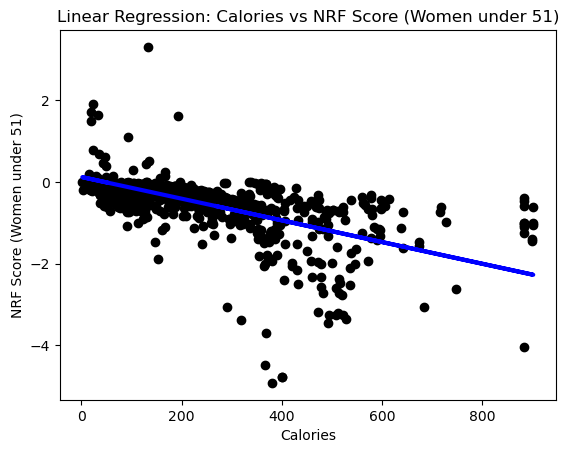

In [28]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Drop rows with missing values in 'calories' or 'NRF_score_women_under51'
data.dropna(subset=['calories', 'NRF_score_women_under51'], inplace=True)

# Split the data into independent (X) and dependent (y) variables
X = data[['calories']]
y = data['NRF_score_women_under51']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the coefficients
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

# Plot the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Calories')
plt.ylabel('NRF Score (Women under 51)')
plt.title('Linear Regression: Calories vs NRF Score (Women under 51)')
plt.show()


In [22]:
#droppign missing 
data.dropna(subset=['calories', 'NRF_score_women_under51'], inplace=True)

Coefficients: [-0.00265637]
Intercept: 0.12265317250380386
Mean Squared Error: 0.3120328719589102
R-squared: 0.30496684563168885


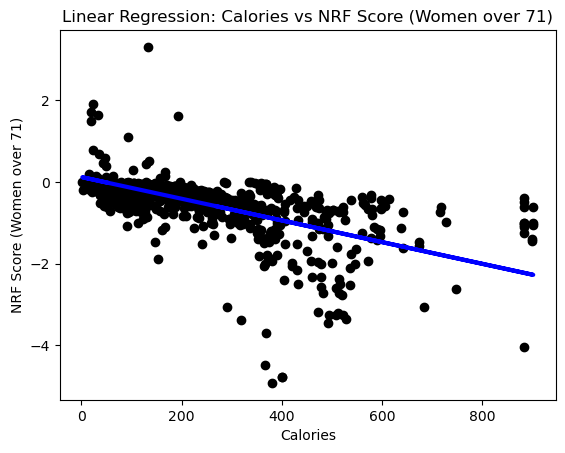

In [24]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Drop rows with missing values in 'calories' or 'NRF_score_women_over71'
data.dropna(subset=['calories', 'NRF_score_women_over71'], inplace=True)

# Split the data into independent (X) and dependent (y) variables
X = data[['calories']]
y = data['NRF_score_women_over71']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the coefficients
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

# Plot the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Calories')
plt.ylabel('NRF Score (Women over 71)')
plt.title('Linear Regression: Calories vs NRF Score (Women over 71)')
plt.show()


Coefficients: [-0.00260928]
Intercept: 0.10427977100905361
Mean Squared Error: 0.29826445016693
R-squared: 0.3083821004830668


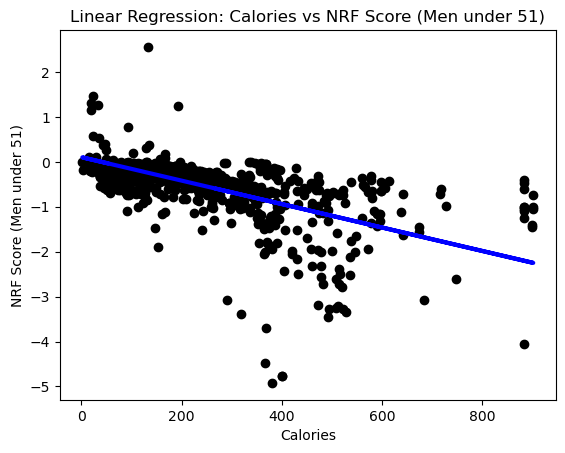

In [27]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Drop rows with missing values in 'calories' or 'NRF_score_men_under51'
data.dropna(subset=['calories', 'NRF_score_men_under51'], inplace=True)

# Split the data into independent (X) and dependent (y) variables
X = data[['calories']]
y = data['NRF_score_men_under51']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the coefficients
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

# Plot the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Calories')
plt.ylabel('NRF Score (Men under 51)')
plt.title('Linear Regression: Calories vs NRF Score (Men under 51)')
plt.show()


Coefficients: [-0.00260928]
Intercept: 0.10427977100905361
Mean Squared Error: 0.29826445016693
R-squared: 0.3083821004830668


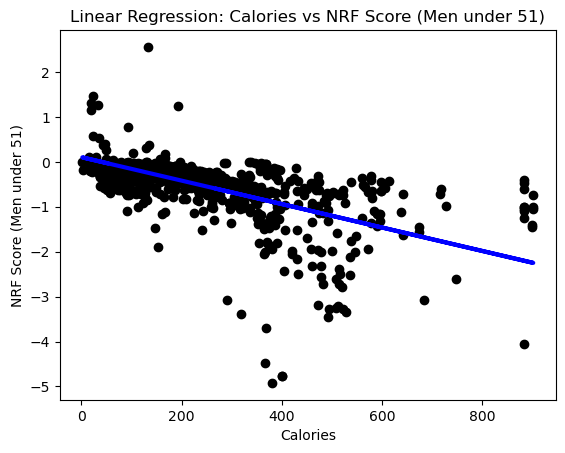

In [29]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame
# Drop rows with missing values in 'calories' or 'NRF_score_men_under51'
data.dropna(subset=['calories', 'NRF_score_men_under51'], inplace=True)

# Split the data into independent (X) and dependent (y) variables
X = data[['calories']]
y = data['NRF_score_men_under51']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the coefficients
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean Squared Error:', mse)
print('R-squared:', r2)

# Plot the regression line
plt.scatter(X_test, y_test, color='black')
plt.plot(X_test, y_pred, color='blue', linewidth=3)
plt.xlabel('Calories')
plt.ylabel('NRF Score (Men under 51)')
plt.title('Linear Regression: Calories vs NRF Score (Men under 51)')
plt.show()


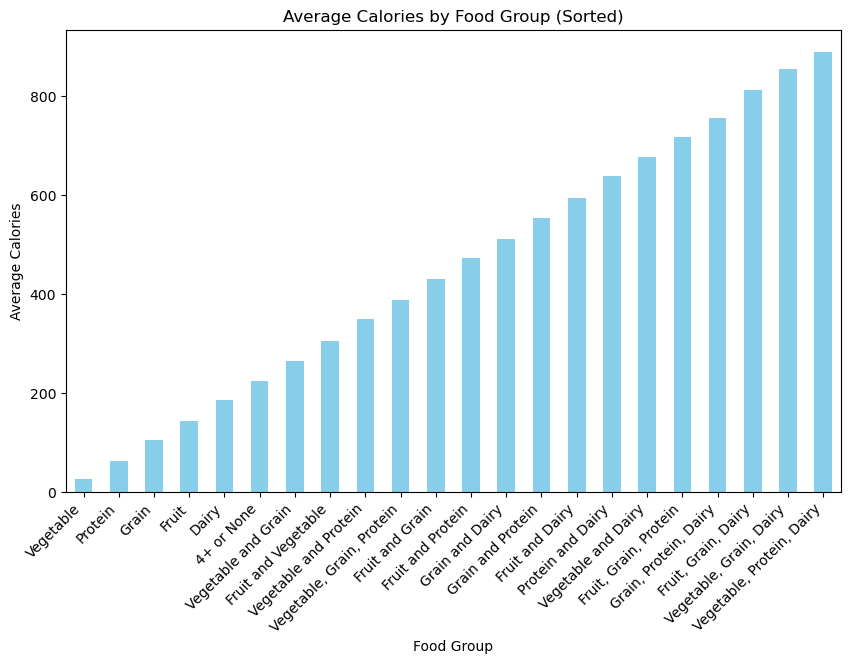

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame

# Convert 'calories' column to numeric, handling errors by setting them to NaN
data['calories'] = pd.to_numeric(data['calories'], errors='coerce')

# If there are non-numeric values in 'calories', you may need to handle or remove them based on your requirements.

# Convert 'food_group' to a categorical type
data['food_group'] = pd.Categorical(data['food_group'], ordered=True, categories=[
    'Vegetable', 'Protein', 'Grain', 'Fruit', 'Dairy', '4+ or None',
    'Vegetable and Grain', 'Fruit and Vegetable',
    'Vegetable and Protein', 'Vegetable, Grain, Protein',
    'Fruit and Grain', 'Fruit and Protein', 'Grain and Dairy',
    'Grain and Protein', 'Fruit and Dairy', 'Protein and Dairy',
    'Vegetable and Dairy', 'Fruit, Grain, Protein',
    'Grain, Protein, Dairy', 'Fruit, Grain, Dairy',
    'Vegetable, Grain, Dairy', 'Vegetable, Protein, Dairy'
])

# Create a new column 'food_group_bin' based on the bins
data['food_group_bin'] = pd.cut(data['calories'], bins=len(data['food_group'].cat.categories), labels=False)

# Map bin labels to actual food group names
bin_labels = data['food_group'].cat.categories
data['food_group_name'] = data['food_group_bin'].map(dict(enumerate(bin_labels)))

# Calculate the average calorie value for each food group
calorie_avg_by_group = data.groupby('food_group_name')['calories'].mean()

# Sort the Series by average calories in ascending order
calorie_avg_by_group = calorie_avg_by_group.sort_values()

# Plot the average calories for each food group
plt.figure(figsize=(10, 6))
calorie_avg_by_group.plot(kind='bar', color='skyblue')
plt.xlabel('Food Group')
plt.ylabel('Average Calories')
plt.title('Average Calories by Food Group (Sorted)')
plt.xticks(rotation=45, ha='right')
plt.show()


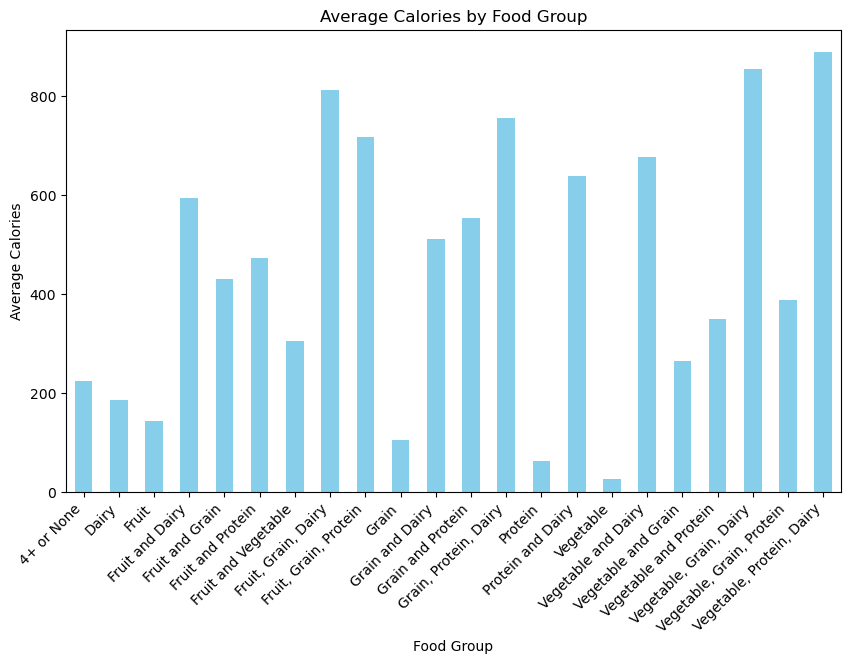

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame

# Convert 'calories' column to numeric, handling errors by setting them to NaN
data['calories'] = pd.to_numeric(data['calories'], errors='coerce')

# If there are non-numeric values in 'calories', you may need to handle or remove them based on your requirements.

# Convert 'food_group' to a categorical type
data['food_group'] = pd.Categorical(data['food_group'], ordered=True, categories=[
    'Vegetable', 'Protein', 'Grain', 'Fruit', 'Dairy', '4+ or None',
    'Vegetable and Grain', 'Fruit and Vegetable',
    'Vegetable and Protein', 'Vegetable, Grain, Protein',
    'Fruit and Grain', 'Fruit and Protein', 'Grain and Dairy',
    'Grain and Protein', 'Fruit and Dairy', 'Protein and Dairy',
    'Vegetable and Dairy', 'Fruit, Grain, Protein',
    'Grain, Protein, Dairy', 'Fruit, Grain, Dairy',
    'Vegetable, Grain, Dairy', 'Vegetable, Protein, Dairy'
])

# Create a new column 'food_group_bin' based on the bins
data['food_group_bin'] = pd.cut(data['calories'], bins=len(data['food_group'].cat.categories), labels=False)

# Map bin labels to actual food group names
bin_labels = data['food_group'].cat.categories
data['food_group_name'] = data['food_group_bin'].map(dict(enumerate(bin_labels)))

# Calculate the average calorie value for each food group
calorie_avg_by_group = data.groupby('food_group_name')['calories'].mean()

# Plot the average calories for each food group
plt.figure(figsize=(10, 6))
calorie_avg_by_group.plot(kind='bar', color='skyblue')
plt.xlabel('Food Group')
plt.ylabel('Average Calories')
plt.title('Average Calories by Food Group')
plt.xticks(rotation=45, ha='right')
plt.show()


In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'data' is your DataFrame

# Select the columns for independent variables
independent_vars = ['total_fat_g', 'cholesterol_mg', 'sodium_mg', 'vitamin_c_mg', 'calcium_mg', 'protein_g', 'carbohydrate_g', 'fiber_g', 'sugars_g']

# Drop rows with missing values in any of the selected columns
data_subset = data.dropna(subset=independent_vars + ['calories'])

# Split the data into independent (X) and dependent (y) variables
X = data_subset[independent_vars]
y = data_subset['calories']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the coefficients
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean Squared Error:', mse)
print('R-squared:', r2)


Coefficients: [ 8.81088038e+00  3.85010714e-03  1.92015724e-04 -3.02965718e-02
 -5.09829373e-03  4.14832933e+00  4.01014092e+00 -1.80121270e+00
 -3.43552021e-02]
Intercept: 1.633314546377477
Mean Squared Error: 61.22254414612399
R-squared: 0.9977004646652065


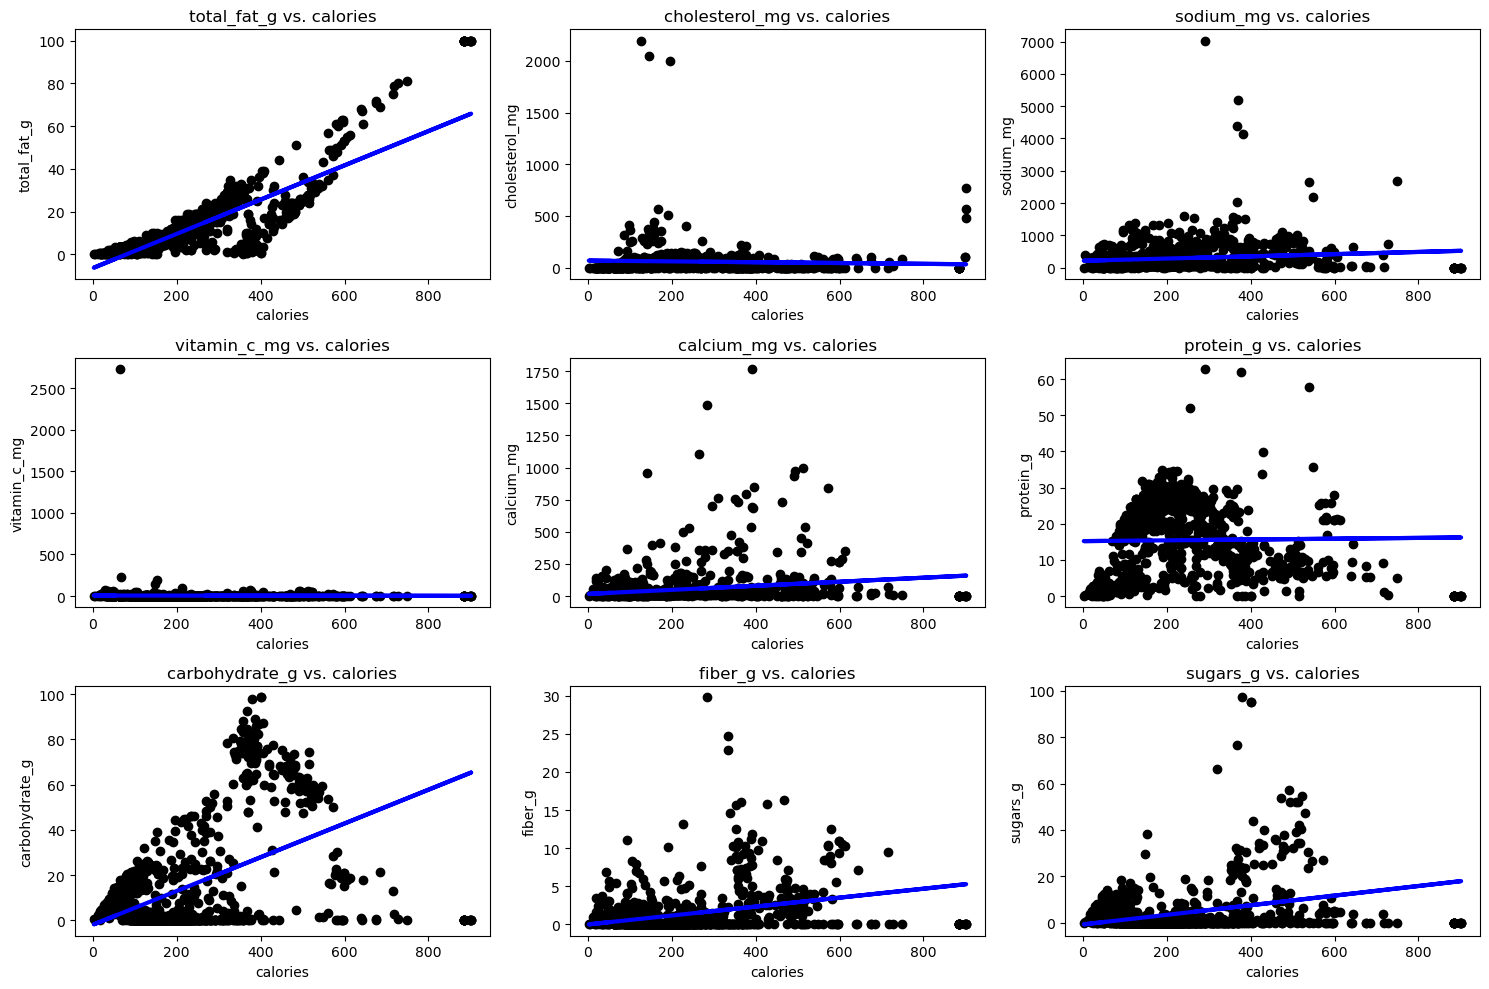

In [37]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame

# Select the columns for independent variables
independent_var = 'calories'

# Select the dependent variables
dependent_vars = ['total_fat_g', 'cholesterol_mg', 'sodium_mg', 'vitamin_c_mg', 'calcium_mg', 'protein_g', 'carbohydrate_g', 'fiber_g', 'sugars_g']

# Plot a separate linear regression for each dependent variable
plt.figure(figsize=(15, 10))
for var in dependent_vars:
    # Drop rows with missing values in the selected columns
    data_subset = data.dropna(subset=[independent_var, var])

    # Split the data into independent (X) and dependent (y) variables
    X = data_subset[[independent_var]]
    y = data_subset[var]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Plot the results
    plt.subplot(3, 3, dependent_vars.index(var) + 1)
    plt.scatter(X_test, y_test, color='black')
    plt.plot(X_test, y_pred, color='blue', linewidth=3)
    plt.title(f'{var} vs. {independent_var}')
    plt.xlabel(independent_var)
    plt.ylabel(var)

plt.tight_layout()
plt.show()


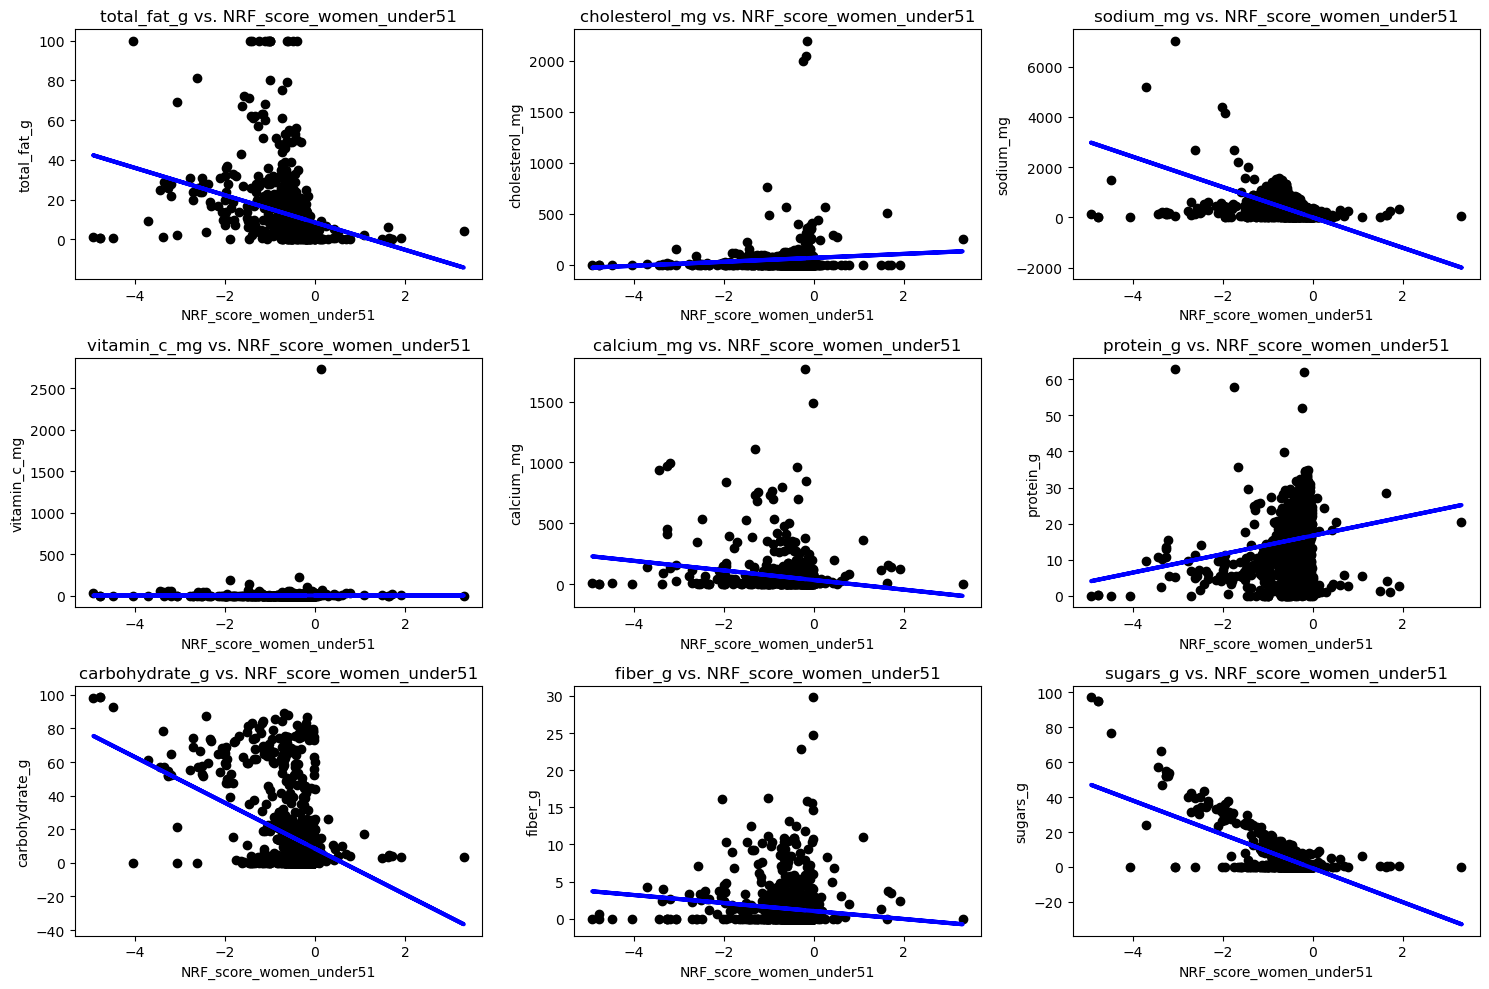

In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame

# Select the independent variable
independent_var = 'NRF_score_women_under51'

# Select the dependent variables
dependent_vars = ['total_fat_g', 'cholesterol_mg', 'sodium_mg', 'vitamin_c_mg', 'calcium_mg', 'protein_g', 'carbohydrate_g', 'fiber_g', 'sugars_g']

# Plot a separate linear regression for each dependent variable
plt.figure(figsize=(15, 10))
for var in dependent_vars:
    # Drop rows with missing values in the selected columns
    data_subset = data.dropna(subset=[independent_var, var])

    # Split the data into independent (X) and dependent (y) variables
    X = data_subset[[independent_var]]
    y = data_subset[var]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Plot the results
    plt.subplot(3, 3, dependent_vars.index(var) + 1)
    plt.scatter(X_test, y_test, color='black')
    plt.plot(X_test, y_pred, color='blue', linewidth=3)
    plt.title(f'{var} vs. {independent_var}')
    plt.xlabel(independent_var)
    plt.ylabel(var)

plt.tight_layout()
plt.show()


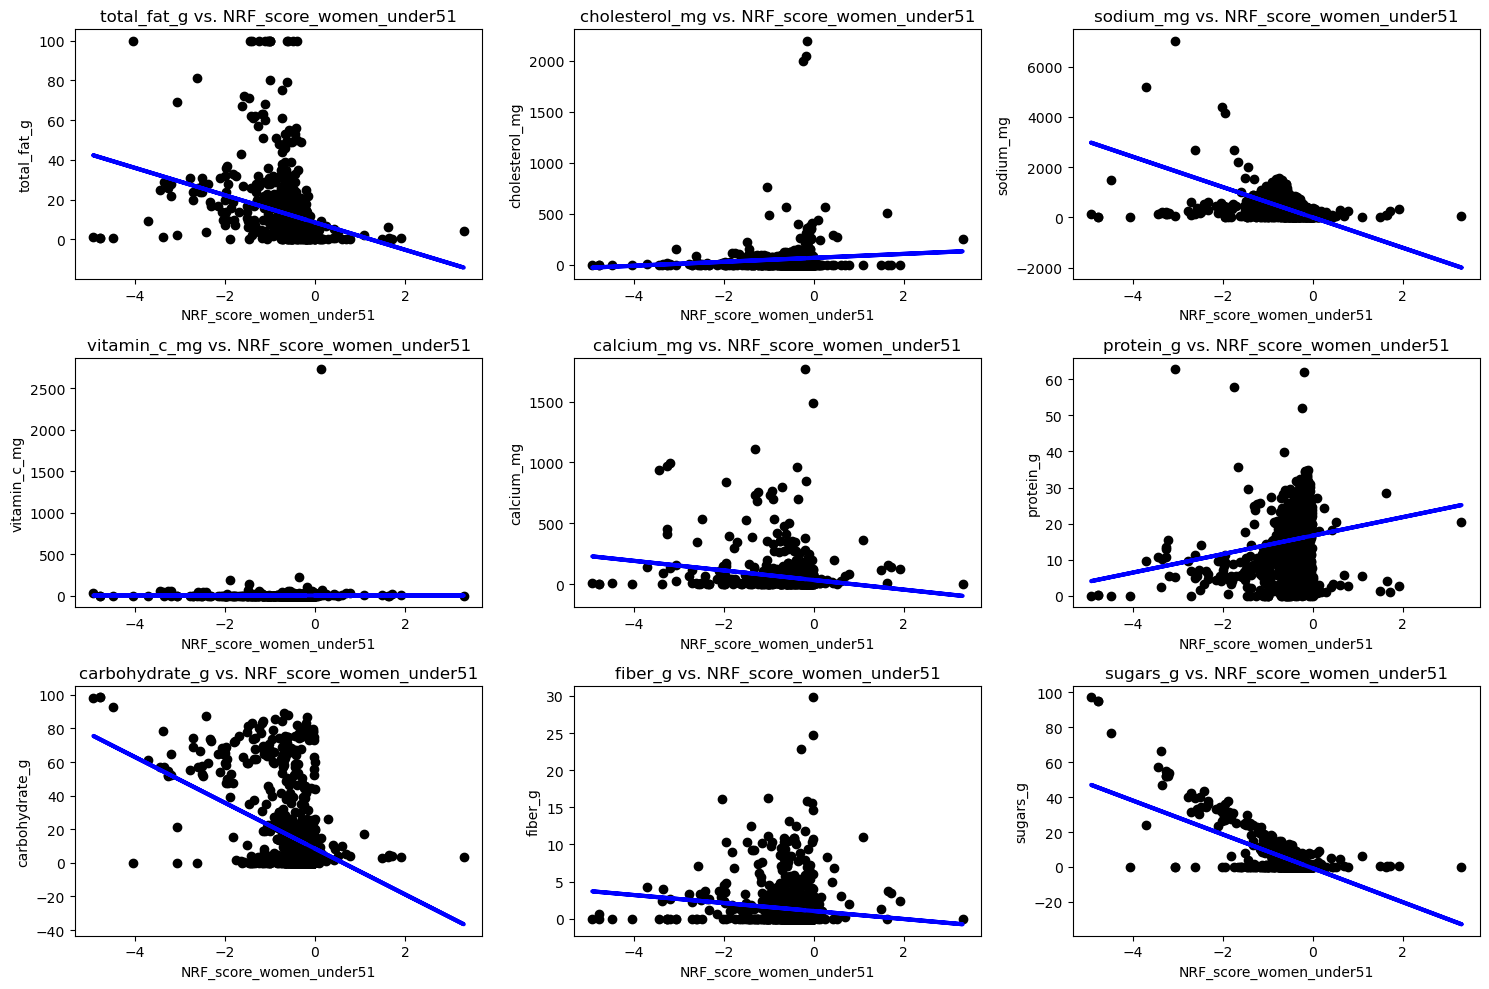

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame

# Select the independent variable
independent_var = 'NRF_score_women_under51'

# Select the dependent variables
dependent_vars = ['total_fat_g', 'cholesterol_mg', 'sodium_mg', 'vitamin_c_mg', 'calcium_mg', 'protein_g', 'carbohydrate_g', 'fiber_g', 'sugars_g']

# Plot a separate linear regression for each dependent variable
plt.figure(figsize=(15, 10))
for var in dependent_vars:
    # Drop rows with missing values in the selected columns
    data_subset = data.dropna(subset=[independent_var, var])

    # Split the data into independent (X) and dependent (y) variables
    X = data_subset[[independent_var]]
    y = data_subset[var]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Plot the results
    plt.subplot(3, 3, dependent_vars.index(var) + 1)
    plt.scatter(X_test, y_test, color='black')
    plt.plot(X_test, y_pred, color='blue', linewidth=3)
    plt.title(f'{var} vs. {independent_var}')
    plt.xlabel(independent_var)
    plt.ylabel(var)

plt.tight_layout()
plt.show()


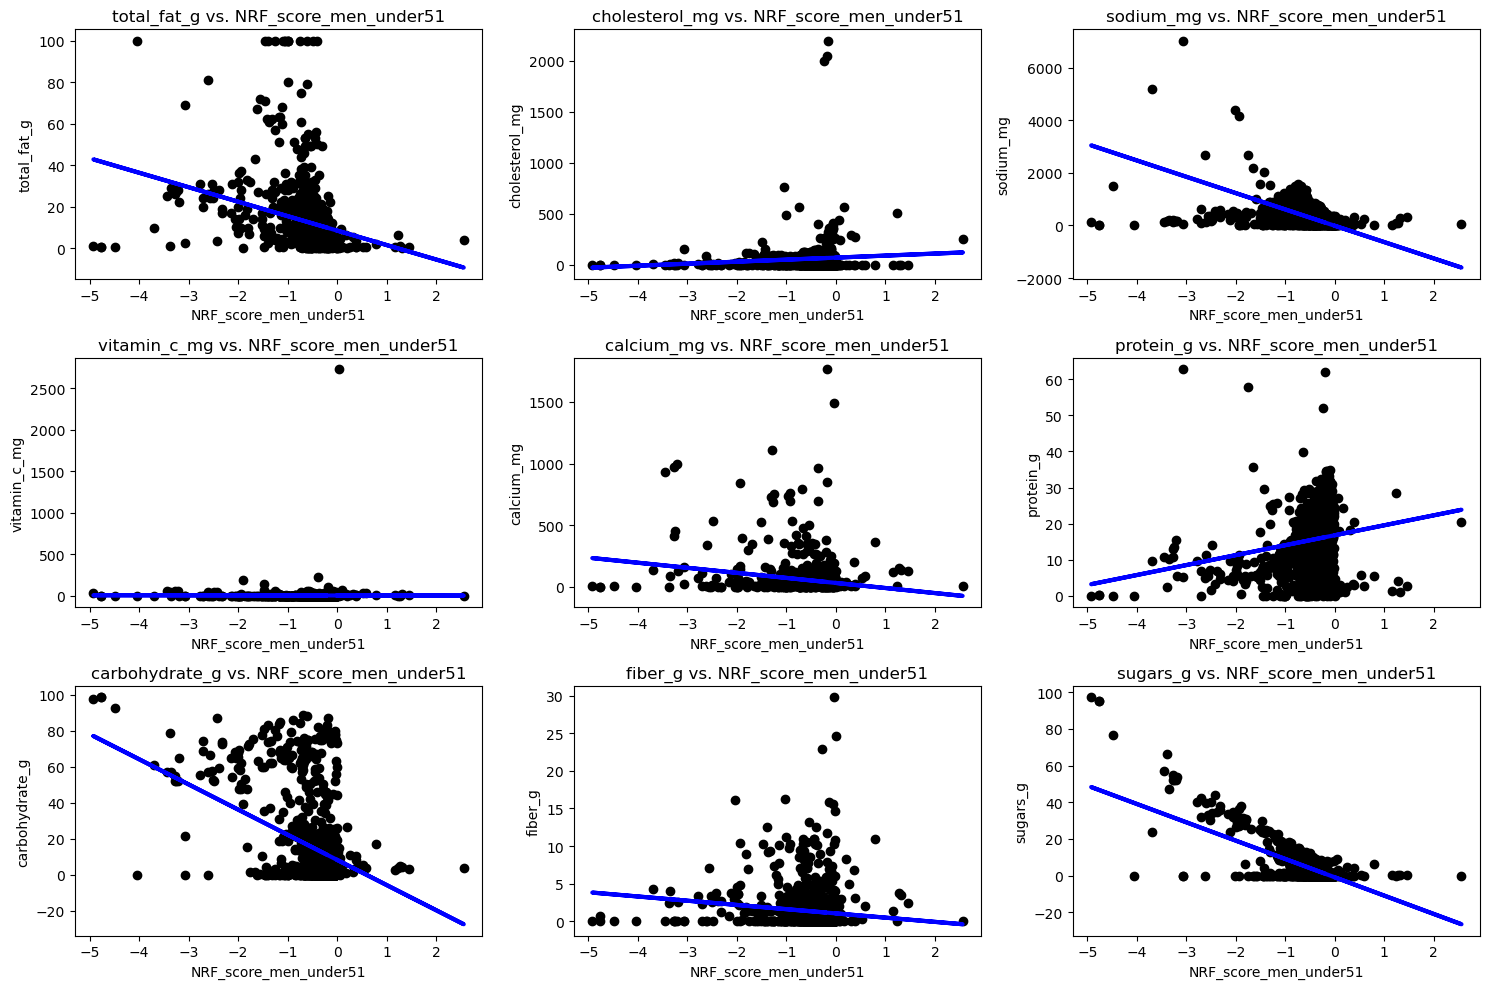

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame

# Select the independent variable
independent_var = 'NRF_score_men_under51'

# Select the dependent variables
dependent_vars = ['total_fat_g', 'cholesterol_mg', 'sodium_mg', 'vitamin_c_mg', 'calcium_mg', 'protein_g', 'carbohydrate_g', 'fiber_g', 'sugars_g']

# Plot a separate linear regression for each dependent variable
plt.figure(figsize=(15, 10))
for var in dependent_vars:
    # Drop rows with missing values in the selected columns
    data_subset = data.dropna(subset=[independent_var, var])

    # Split the data into independent (X) and dependent (y) variables
    X = data_subset[[independent_var]]
    y = data_subset[var]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Plot the results
    plt.subplot(3, 3, dependent_vars.index(var) + 1)
    plt.scatter(X_test, y_test, color='black')
    plt.plot(X_test, y_pred, color='blue', linewidth=3)
    plt.title(f'{var} vs. {independent_var}')
    plt.xlabel(independent_var)
    plt.ylabel(var)

plt.tight_layout()
plt.show()


C:\Users\14048\AppData\Local\Temp\ipykernel_18256\1762045545.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_scores = data.groupby('food_group')[['NRF_score_men_under51', 'NRF_score_women_under51']].mean()


<Figure size 1200x600 with 0 Axes>

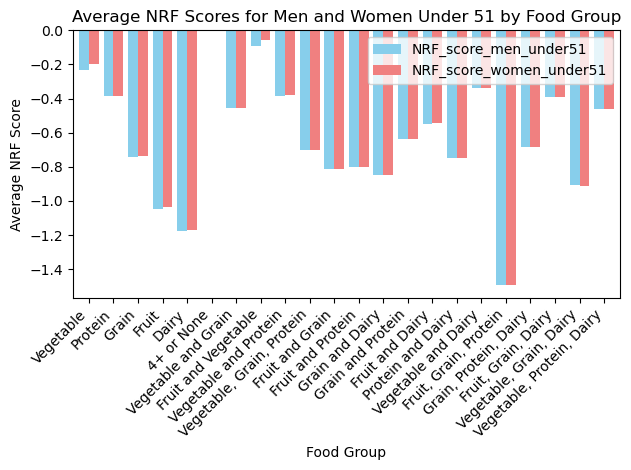

In [41]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'data' is your DataFrame

# Group by food group and calculate the mean scores for men and women
average_scores = data.groupby('food_group')[['NRF_score_men_under51', 'NRF_score_women_under51']].mean()

# Plot the results
plt.figure(figsize=(12, 6))
average_scores.plot(kind='bar', width=0.8, color=['skyblue', 'lightcoral'])
plt.xlabel('Food Group')
plt.ylabel('Average NRF Score')
plt.title('Average NRF Scores for Men and Women Under 51 by Food Group')
plt.legend(loc='upper right')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [42]:
import pandas as pd

# Assuming 'data' is your DataFrame

# Group by food group and calculate the mean scores for men and women
average_scores = data.groupby('food_group')[['NRF_score_men_under51', 'NRF_score_women_under51']].mean()

# Find the food group with the highest and lowest average NRF score for men
highest_men_group = average_scores['NRF_score_men_under51'].idxmax()
lowest_men_group = average_scores['NRF_score_men_under51'].idxmin()

# Find the food group with the highest and lowest average NRF score for women
highest_women_group = average_scores['NRF_score_women_under51'].idxmax()
lowest_women_group = average_scores['NRF_score_women_under51'].idxmin()

# Display the results
print("Highest Average NRF Score for Men:", highest_men_group, average_scores['NRF_score_men_under51'].max())
print("Lowest Average NRF Score for Men:", lowest_men_group, average_scores['NRF_score_men_under51'].min())
print("Highest Average NRF Score for Women:", highest_women_group, average_scores['NRF_score_women_under51'].max())
print("Lowest Average NRF Score for Women:", lowest_women_group, average_scores['NRF_score_women_under51'].min())


Highest Average NRF Score for Men: Fruit and Vegetable -0.09251573786738322
Lowest Average NRF Score for Men: Fruit, Grain, Protein -1.493876018787482
Highest Average NRF Score for Women: Fruit and Vegetable -0.054528447614125425
Lowest Average NRF Score for Women: Fruit, Grain, Protein -1.492568863515944


C:\Users\14048\AppData\Local\Temp\ipykernel_18256\962352671.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_scores = data.groupby('food_group')[['NRF_score_men_under51', 'NRF_score_women_under51']].mean()
